## 4.2. Generating embeddings 

Commands: 
LLAMA_HOST=127.0.0.1:11435 OLLAMA_MODELS=/cluster/courses/ml4h/llm/models /cluster/courses/ml4h/llm/bin/ollama serve

/cluster/courses/ml4h/llm/bin/ollama list

In [2]:
import pandas as pd
from ollama import embed
import numpy as np

X = pd.read_parquet('LLM/b_with_descriptions.parquet')
inputs = list(X['description'])
for i in inputs:
    response = embed(model='llama3.1:8b', input=i)
    embedding_array = np.array(response["embeddings"])
    string = f"LLM_emb_testing_set/embeddings_{count}.npz"
    np.savez(string, embedding_array)
    print(count)
    count+=1

2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769


## Linear probe

In [ ]:
!unzip llm_emb_test.zip -d LLM_emb_testing_set/
!unzip llm_emb_train.zip -d LLM_emb_training_set/

In [4]:
import numpy as np
import glob
import pandas as pd
npy_files = sorted(glob.glob("LLM_emb_training_set/*.npy"))

embeddings_list = []
for file_path in npy_files:
    arr = np.load(file_path)  # shape should be (D,)
    arr = arr.squeeze(axis=0)
    embeddings_list.append(arr)
X_train = np.stack(embeddings_list, axis=0) 
print(X_train.shape)

y_train = pd.read_parquet('processed-data/processed-outcomes-a.parquet')["In-hospital_death"].to_numpy().flatten()

(4000, 4096)


In [7]:
npy_files = sorted(glob.glob("LLM_emb_testing_set/*.npz"))

embeddings_list = []
for file_path in npy_files:
    data = np.load(file_path)
    arr_keys = data.files
    if len(arr_keys) == 1:
        arr = data[arr_keys[0]]
        #print(arr.shape)
    else:
        print(f"Multiple arrays in {file_path}: {arr_keys}")
    embeddings_list.append(arr.squeeze(axis=0))
X_test = np.stack(embeddings_list, axis=0) 
print(X_test.shape)

y_test = pd.read_parquet('processed-data/processed-outcomes-c.parquet')["In-hospital_death"].to_numpy().flatten()

(4000, 4096)


### Linear regression 

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Initialize and train the logistic regression
log_reg = LogisticRegression()  # you can specify hyperparams if you wish
log_reg.fit(X_train, y_train)

# Evaluate on test set
y_pred = log_reg.predict_proba(X_test)[:, 1] 

from sklearn.metrics import roc_auc_score, average_precision_score

roc = roc_auc_score(y_test, y_pred)  # Area under the ROC curve
prc = average_precision_score(y_test, y_pred)  # Area under the Precision-Recall curve

print("ROC AUC:", roc)
print("PR AUC:", prc)

ROC AUC: 0.5106621115991541
PR AUC: 0.15259355861311713


## 3. Visualization with tsne

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import glob
from datetime import datetime
import math
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, silhouette_score, adjusted_rand_score, roc_curve, precision_recall_curve
from sklearn.metrics import normalized_mutual_info_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
import random

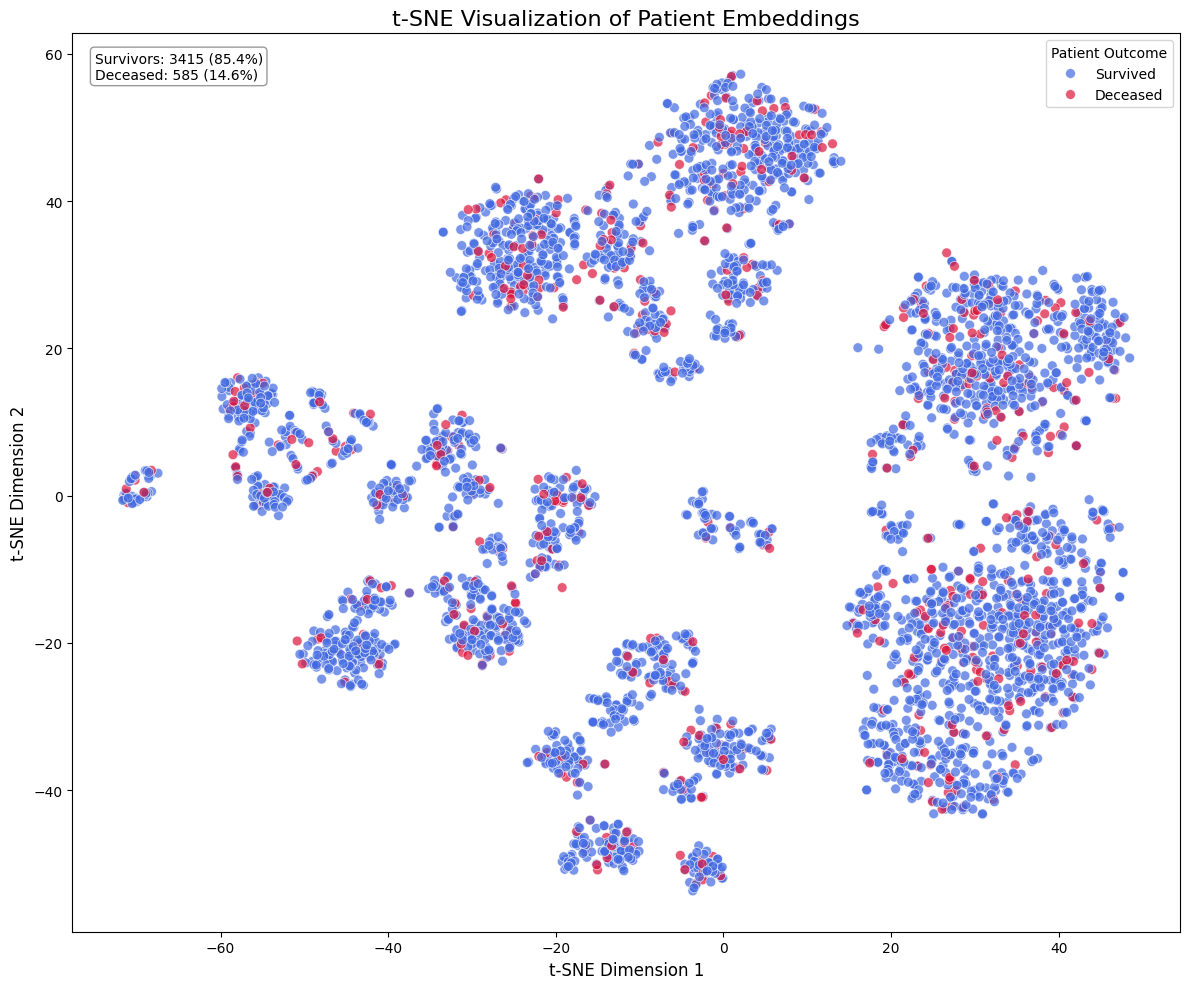

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
#Visualization of test set only
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)

# Convert PyTorch tensors to NumPy arrays
# X_test_np = X.numpy()  # Move to CPU if on GPU and convert to NumPy
# y_test_np = y.numpy() if isinstance(y_test, torch.Tensor) else y_test

X_test_np = X_test
y_test_np = y_test
# Fit t-SNE
X_tsne = tsne.fit_transform(X_test_np)

# Create DataFrame for visualization
tsne_df = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'label': y_test_np
})

tsne_df['label'] = tsne_df['label'].astype('category')

# Plot with different colors for labels 0 or 1
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    x='x', y='y',
    hue='label',
    palette={0: 'royalblue', 1: 'crimson'},
    data=tsne_df,
    alpha=0.7,
    s=50,
)

handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Survived', 'Deceased'], title='Patient Outcome')
plt.title('t-SNE Visualization of Patient Embeddings', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

survivors = (y_test_np == 0).sum()
deceased = (y_test_np == 1).sum()
total = len(y_test_np)

plt.annotate(f'Survivors: {survivors} ({survivors/total:.1%})\nDeceased: {deceased} ({deceased/total:.1%})',
             xy=(0.02, 0.98), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             ha='left', va='top', fontsize=10)

plt.tight_layout()
plt.savefig('tsne_visualization_test.png', dpi=300)
plt.show()

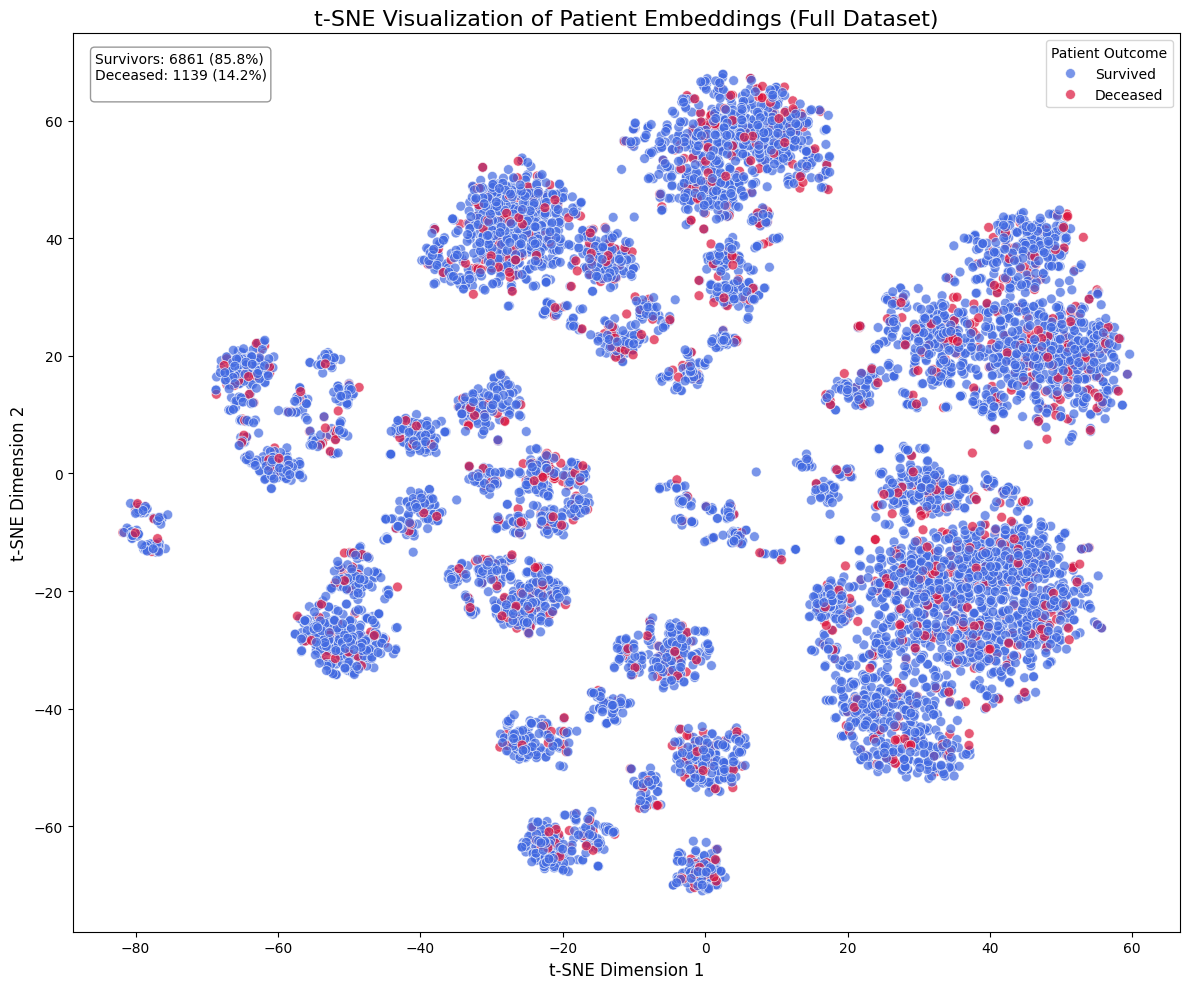

In [12]:
# # Combine all sets
# X_combined = torch.cat([X_train, X_test], dim=0)
# if isinstance(y_train, torch.Tensor):
#     y_combined = torch.cat([y_train, y_test], dim=0)
# else:
#     y_combined = np.concatenate([y_train, y_test, y_val])

# # Create set labels to track which dataset each point came from
set_labels = np.array(['Train'] * len(X_train) + ['Test'] * len(X_test))

# # Convert to NumPy arrays for t-SNE
# X_combined_np = X_combined.cpu().numpy()
# y_combined_np = y_combined.cpu().numpy() if isinstance(y_combined, torch.Tensor) else y_combined

X_combined_np = np.concatenate((X_train, X_test), axis=0)
y_combined_np = np.concatenate((y_train, y_test), axis=0)
# Fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_combined_np)

# Create DataFrame for visualization
tsne_df = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'outcome': y_combined_np,
    'dataset': set_labels
})

# Convert to category
tsne_df['outcome'] = tsne_df['outcome'].astype('category')

# Create a single plot colored by outcome
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    x='x', y='y',
    hue='outcome',
    palette={0: 'royalblue', 1: 'crimson'},
    data=tsne_df,
    alpha=0.7,
    s=50,
)

handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Survived', 'Deceased'], title='Patient Outcome')
plt.title('t-SNE Visualization of Patient Embeddings (Full Dataset)', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

# Add statistics annotation
survivors = (y_combined_np == 0).sum()
deceased = (y_combined_np == 1).sum()
total = len(y_combined_np)

stats_text = (f'Survivors: {survivors} ({survivors/total:.1%})\n'
              f'Deceased: {deceased} ({deceased/total:.1%})\n')

plt.annotate(stats_text, xy=(0.02, 0.98), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             ha='left', va='top', fontsize=10)

plt.tight_layout()
plt.savefig('combined_tsne_visualization.png', dpi=300)
plt.show()

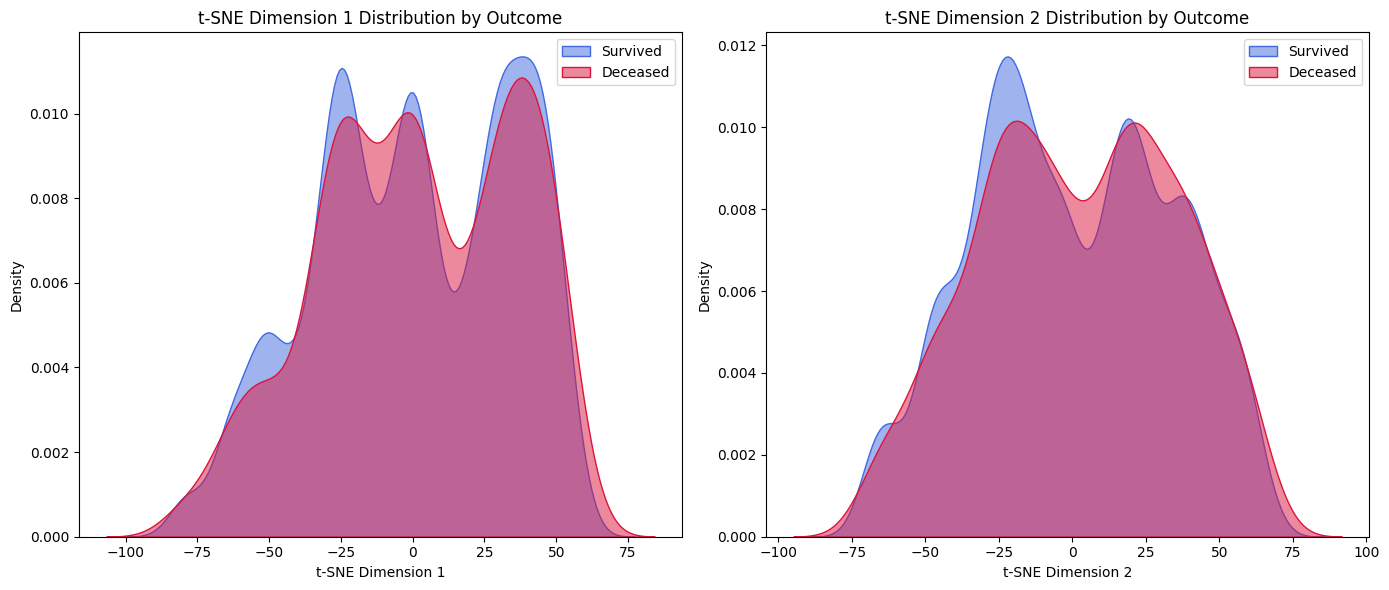

In [10]:
# Separate visualization with density plots for each class, two subplots for dimension 1 and 2
plt.figure(figsize=(14, 6))
for i, dim in enumerate(['x', 'y']):
    plt.subplot(1, 2, i+1)
    for label, color in zip([0, 1], ['royalblue', 'crimson']):
        subset = tsne_df[tsne_df['outcome'] == label]  # Changed 'label' to 'outcome'
        sns.kdeplot(subset[dim], fill=True, color=color, alpha=0.5, 
                   label='Survived' if label == 0 else 'Deceased')
    
    plt.title(f't-SNE Dimension {i+1} Distribution by Outcome')
    plt.xlabel(f't-SNE Dimension {i+1}')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig('llm_embedding_tsne_density_by_class.png', dpi=300)
plt.show()